In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from io import StringIO
from enum import Enum
from typing import NamedTuple, Callable

%matplotlib inline


### MGD77 NOTEBOOK 
#### (MARINE GEOPHYSICAL DATA EXCHANGE FORMAT)

In [3]:
def build_mgb77_header(institut : str) -> str :
    return f"""414000700MGD77            5550020151103GENAVIR,IFREMER                        01
FRANCE            ATALANTE             1SHIP  LOSSOUARN Hubert                02
TV_PAPMAC(SMT)                                            {institut}          03
20140315Pointe-a-Pitre (Guadeloupe)     20140401Maceio (Brazil)               04
Differential GPS                        WGS 84                                05
SBES SIMRAD EK6012                                                            06
OVERHAUSER MAG. MARINE MAGNETICS SEASPY                                       07
BODENSEEWERK KSS31                                                            08
                                                                              09
A(I1,A8,I3,I4,3I2,F5.3,F8.5,F9.5,I1,F6.4,F6.1,I2,I1,3F6.1,I1,F5.1,F6.0,F7.1,  10
F6.1,F5.1,A5,A6,I1)                                                           11
 10                 00SEE SEQ. 18                                             12
 10  0342        88IGRF-2005                                                  13
 10  4GRS 1980         9                REF. DATA(T1,G01;T2,G02) IN SEQ. 23+2414
                                                                              15
                                                                              16
                                                                              17
LIN.INTERP.:MAX FILLED GAP (SEC):N=   120/B=   300/M=   600/G=   600/         18
                                                                              19
MAGNETICS : IGRF COEF. INTERPOLATED AT THE DATE OF THE VALUE                  20
GRAVITY : CORRECTION APPLIED FOR FILTER DELAY T=T+   0 secondes               21
                                                                              22
(14/ 3/13,980889.3;14/ 4/20,980889.9);                                        23
                                                                              24\n"""

In [2]:
class Mgd77DataRecord(NamedTuple):
    start: int
    end: int = None
    desc: str = None
    default: str = None
    read_formatter : Callable[[str], str] =  lambda s : int(s)
    write_formatter : Callable = lambda v : str(v)
    
NAN_VALUE = 999999 # during write operation, nan values has been replaced by this one to allow the use of write_formatter
debug = False
class Mgd77Data(Mgd77DataRecord, Enum):
    """
    Enumeration of MGD77 data record.
    """
    
    DATA_RECORD_TYPE = Mgd77DataRecord(1, 1, desc = "Data record type : set to '5' for data record.",
                    write_formatter = lambda value : ('[rectype]' if debug else '') + (f'{value:01.0f}' if value != NAN_VALUE else '9'))
    
    SURVEY_IDENTIFIER = Mgd77DataRecord(2, 9,
                    desc = "Survey identifier supplied by the contributing organization, else given by NGDC in a manner which represents the data.",
                    write_formatter = lambda value : ('[surveyId]' if debug else '') + (f'{value:08.0f}' if value != NAN_VALUE else '99999999'))
   
    TIME_ZONE_CORRECTION = Mgd77DataRecord(10, 12,
                    desc = """Corrects time (in characters 13-27) to GMT when added: equals zero when time is GMT. 
                            Timezone normally falls between -13 and +12 inclusively.""",
                    read_formatter = lambda sting_value : int(sting_value),
                    #should have sign ?
                    write_formatter = lambda value : ('[timezone]' if debug else '') + (f'{value:+03.0f}' if value != NAN_VALUE else '+00'))
    
    DATE_TIME = Mgd77DataRecord(13, 27, 
                    desc = "Date time : YYYYMMDD + HOUR + MINUTES x 1000", 
                    # parse MGD77 datetime (YYYYMMDD + HOUR + MINUTES x 1000)
                    read_formatter= lambda date: pd.to_datetime(date[:-3] + str(int(int(date[-3:]) / 1000 * 60)), format='%Y%m%d%H%M%S'),
                    write_formatter = lambda date_time : ('[time]' if debug else '') + date_time.strftime('%Y%m%d%H')+ f'{(date_time.minute + date_time.second)*1000:05}')
    
    LATITUDE = Mgd77DataRecord(28, 35, 
                    desc = "Latitude x 100000; + = North; - = South; Between -9000000 and 9000000",
                    read_formatter = lambda lat_str : int(lat_str)/100_000 if lat_str != '+9999999' else np.nan,
                    write_formatter = lambda lat : ('[lat]' if debug else '') + (f'{lat*100_000:+08.0f}' if lat != NAN_VALUE else '+9999999'))
    
    LONGITUDE = Mgd77DataRecord(36, 44, 
                    desc = "Longitude x 100000; + = East; - = West; Between -18000000 and 18000000",
                    read_formatter = lambda lon_str : int(lon_str)/100_000 if lon_str != '+99999999' else np.nan,
                    write_formatter = lambda lon : ('[lon]' if debug else '') + (f'{lon*100_000:+09.0f}' if lon != NAN_VALUE else '+99999999'))
                               
    
    POSITION_TYPE_CODE = Mgd77DataRecord(45, 45, 
                    desc = "Position type code : indicates how lat/lon was obtained: 1 = Observed fix; 3 = Interpolated; 9 = Unspecified",
                    write_formatter = lambda value : ('[posCode]' if debug else '') + (f'{value:01.0f}' if value != NAN_VALUE else '9'))
    
    BATHYMETRY_2_WAY_TRAVELTIME = Mgd77DataRecord(46, 51, 
                    desc = """Bathymetry 2 way traveltime in ten-thousandths of seconds. Corrected for transducer depth and other such corrections, especially in shallow water""",
                    read_formatter = lambda sting_value : int(sting_value) / 100 if sting_value != '999999' else np.nan,
                    write_formatter = lambda value : ('[2wtt]' if debug else '') + (f'{value*100:06.0f}' if value != NAN_VALUE else '999999'))
    
    BATHYMETRY_CORRECTED_DEPTH = Mgd77DataRecord(52, 57, "Bathymetry corrected depth in tenths of meters.",
                    read_formatter = lambda sting_value : int(sting_value) / 10 if sting_value != '999999' else np.nan,
                    write_formatter = lambda value : ('[depth]' if debug else '') + (f'{value*10:06.0f}' if value != NAN_VALUE else '999999'))
    
    BATHYMETRIC_CORRECTION_CODE = Mgd77DataRecord(58, 59,
                    desc = """Bathymetric correction code : details the procedure used for determining the sound velocity correction to depth: 
                                    01-55 Matthews' Zones with zone; 
                                    59 Matthews' Zones, no zone; 
                                    60 S. Kuwahara Formula; 
                                    61 Wilson Formula; 
                                    62 Del Grosso Formula; 
                                    63 Carter's Tables; 
                                    88 Other (see Add. Doc.); 
                                    99 Unspecified""",
                    write_formatter = lambda value : ('[bathy_corr]' if debug else '') + (str(value) if value != NAN_VALUE else '99')) # why not 99 ?
    
    BATHYMETRIC_TYPE_CODE = Mgd77DataRecord(60, 60,"""Bathymetric type code : indicates how the data record's bathymetric value was obtained: 
                                    1 = Observed; 
                                    3 = Interpolated (Header Seq. 12); 
                                    9 = Unspecified""",
                    write_formatter = lambda value : ('[bathy_type]' if debug else '') + (f'{value:01.0f}' if value != NAN_VALUE else '9'))
    
    MAGNETICS_TOTAL_FIELD_1 = Mgd77DataRecord(61, 66, 
                    desc = """Magnetics total field for 1st sensor in tenths of nanoteslas (gammas). 
                                For leading sensor. Use this field for single sensor.""",
                    read_formatter = lambda sting_value : int(sting_value) / 10 if sting_value != '999999' else np.nan,
                    write_formatter = lambda value : ('[mag1]' if debug else '') + (f'{value*10:06.0f}' if value != NAN_VALUE else '999999'))
    
    MAGNETICS_TOTAL_FIELD_2 = Mgd77DataRecord(67, 72,
                    desc = "Magnetics total field for 2nd sensor in tenths of nanoteslas (gammas). For trailing sensor.",
                    read_formatter = lambda sting_value : int(sting_value) / 10 if sting_value != '999999' else np.nan,
                    write_formatter = lambda value : ('[mag2]' if debug else '') + (f'{value*10:06.0f}' if value != NAN_VALUE else '999999'))
    
    MAGNETICS_RESIDUAL_FIELD = Mgd77DataRecord(73, 78,
                    desc = "Magnetics residual field In tenths of nanoteslas (gammas). The reference field used is in Header Seq. 13.",
                    read_formatter = lambda sting_value : int(sting_value) / 10 if sting_value != '999999' else np.nan,
                    write_formatter = lambda value : ('[magr]' if debug else '') + (f'{value*10:06.0f}' if value != NAN_VALUE else '999999'))
    
    SENSOR_FOR_RESIDUAL_FIELD = Mgd77DataRecord(79, 79,  """Sensor for residual field : 
                                    1 = 1st or leading sensor; 
                                    2 = 2nd or trailing sensor;
                                    9 = Unspecified""",
                    write_formatter = lambda value : ('[magrSensor]' if debug else '') + (f'{value:01.0f}' if value != NAN_VALUE else '9'))
    
    MAGNETICS_DIURNAL_CORRECTION = Mgd77DataRecord(80, 84, 
                    desc = """Magnetics diurnal correction in tenths of nanoteslas (gammas). (In nanoteslas) 
                    if 9-filled (i.e., set to +9999), total and residual fields are assumed to be uncorrected;
                    if used, total and residuals are assumed to have been already corrected.""",
                    read_formatter = lambda sting_value : int(sting_value) / 10 if sting_value != '+9999' else np.nan,
                    write_formatter = lambda value : ('[magdiu]' if debug else '') + (f'{value*10:+04.0f}' if value != NAN_VALUE else '+9999'))
    
    DEPTH_OR_ALTITUDE_OF_MAGNETICS_SENSOR = Mgd77DataRecord(85, 90,
                    desc = "Depth or altitude of magnetics sensor in meters. + = Below sealevel - = Above sealevel",
                    read_formatter = lambda sting_value : int(sting_value) if sting_value != '+99999' else np.nan,
                    write_formatter = lambda value : ('[magdepth]' if debug else '') + (f'{value:+06.0f}' if value != NAN_VALUE else '+99999'))
    
    OBSERVED_GRAVITY = Mgd77DataRecord(91,  97, 
                    desc = "Observed gravitry in tenths of milligals. Corrected for Eotvos, drift, and tares.",
                    read_formatter = lambda sting_value : int(sting_value)/10 if sting_value != '9999999' and sting_value != '+999999' else np.nan,
                    write_formatter = lambda value : ('[gravi]' if debug else '') + (f'{value*10:07.0f}' if value != NAN_VALUE else '9999999'))
    
    EOTVOS_CORRECTION = Mgd77DataRecord(98, 103, "Eotvos correciton in tenths of milligals. E = 7.5 V cos phi sin alpha + 0.0042 V*V",
                    read_formatter = lambda sting_value : (int(sting_value)/10) if sting_value != '999999' else np.nan,
                    write_formatter = lambda value : ('[eotvos]' if debug else '') + (f'{value*10:+06.0f}' if value != NAN_VALUE else '999999'))
    
    FREE_AIR_ANOMALY = Mgd77DataRecord(104, 108,"Free air anomaly in tenths of milligals. Free-air Anomaly = G(observed) - G(theoretical)",
                    read_formatter = lambda sting_value : int(sting_value)/10 if sting_value != '99999' and sting_value != '+9999' else np.nan,
                    write_formatter = lambda value : ('[faa]' if debug else '') + (f'{value*10:+05.0f}' if value != NAN_VALUE else '99999'))
    
    SEISMIC_LINE_NUMBER = Mgd77DataRecord(109, 113, "Seismic line number used for cross referencing with seismic data.",
                    read_formatter = lambda sting_value : int(sting_value) if sting_value != '99999' else np.nan,
                    write_formatter = lambda value : ('[seiLine]' if debug else '') + (str(value) if value != NAN_VALUE else '99999'))
    
    SEISMIC_SHOT_POINT_NUMBER = Mgd77DataRecord(114, 119, "Seismic shot point number.",
                    read_formatter = lambda sting_value : int(sting_value) if sting_value != '999999' else np.nan,
                    write_formatter = lambda value : ('[seiPoint]' if debug else '') + (f'{value:06.0f}' if value != NAN_VALUE else '999999'))
    
    QUALITY_CODE_FOR_NAVIGATION = Mgd77DataRecord(120, 120, """Quality code for navigation : 
                                        5 = Suspected, by the originating institution; 
                                        6 = Suspected, by the data center; 
                                        9 = No identifiable problem	found""",
                    write_formatter = lambda value : ('[quality]' if debug else '') + (f'{value:01.0f}' if value != NAN_VALUE else '9'))

### Methods

In [4]:
def read_mgd77(file_path : str) -> xr.Dataset:
    """ Read an MGD77 file and return an Xarray dataset """
    # get column names, positions and converters from Mgd77Data enum
    col_names = []
    col_specs = []
    converters = {}
    for record in Mgd77Data :
        col_names.append(record.name)
        col_specs.append((record.start - 1, record.end))
        converters[record.name] = record.read_formatter
    # read with pandas
    df = pd.read_fwf(mgd77_file, colspecs=col_specs, header=None, skiprows=24, names=col_names, converters = converters)
    # convert to xarray
    ds = xr.Dataset.from_dataframe(df)
    # index by datetime 
    #ds = ds.set_coords(Mgd77Data.DATE_TIME.name)
    ds = ds.set_index(index=[Mgd77Data.DATE_TIME.name])
    ds = ds.rename(index=Mgd77Data.DATE_TIME.name)
    return ds

In [5]:
def write_mgd77(input_ds : xr.Dataset, output_file_path : str):
    print('write_mgd77...')
    # column name & formatters
    columns = []
    formatters = {}
    nan_arrray = np.full(input_ds.dims['DATE_TIME'], np.nan)
    for record in Mgd77Data :
        columns.append(record.name)
        formatters[record.name] = record.write_formatter
        # fill dataset with missing array filled with NaN
        if record.name not in input_ds:
            input_ds[record.name] = xr.DataArray(data = nan_arrray, dims = input_ds.dims)
        
    # convert to pandas dataframe
    df = input_ds.to_dataframe()
    df['DATE_TIME'] = input_ds["DATE_TIME"].to_pandas() 
    df = df.replace(np.nan, 999999) # replace NaN values because they are not handled by formatters
    
    # data 
    data_lines = df.to_string(header=False, index=False, index_names=False, columns=columns, justify="justify-all", formatters=formatters).replace(' ', '')
    
    #header
    header = build_mgb77_header('test')
    
    print('write file...')
    with open(output_file_path, "w", encoding="utf-8") as f:
        f.write(header)
        f.write(data_lines)
        f.flush()

In [6]:
def export_to_mgd77(gravi_file: str, mag_file: str):
    """Converts TECHSAS files (gravimetry, magnetism & depth) to MGD77 """
    print('export_to_mgd77...')
    with xr.open_dataset(gravi_file) as gravi_ds, xr.open_dataset(mag_file) as mag_ds:
        
        gravi_ds_2 = xr.Dataset(
             data_vars = {
                Mgd77Data.LONGITUDE.name: (["time"], gravi_ds['lon'].data),
                Mgd77Data.LATITUDE.name: (["time"], gravi_ds['lat'].data),
                Mgd77Data.OBSERVED_GRAVITY.name: (["time"], gravi_ds['real_gravity'].data),
                Mgd77Data.EOTVOS_CORRECTION.name: (["time"], gravi_ds['eotvos_correction'].data),
                Mgd77Data.FREE_AIR_ANOMALY.name: (["time"], gravi_ds['computed_free_air_anomalies'].data)
             },
            coords = {
                "time" : gravi_ds['time']
            }).resample(time='60S').mean()
        
        mag_ds_2 = xr.Dataset(
             data_vars = {
                Mgd77Data.MAGNETICS_TOTAL_FIELD_1.name: (["time"], mag_ds['mag'].data)
             },
            coords = {
                "time" : mag_ds['time']
            }).resample(time='60S').mean()
    
        result_ds = gravi_ds_2.merge(mag_ds_2)
        result_ds = result_ds.rename(time=Mgd77Data.DATE_TIME.name)
        return result_ds

---
### TESTS

In [7]:
base_path = "C://Users//gbillant//Desktop//test_gravi//2014000700//"
gravi_file = base_path + "201400070045-KSS-AT_KSS31M_processed.gravi.nc"
mag_file = base_path + "201400070045-scalar_mag-AT_MAGSS_processed.mag.nc"
mgd77_file = base_path + "201400070062.mgd77"

#### Exemple : read an MGD77 file

In [8]:
mgd77_ds = read_mgd77(mgd77_file)

DATA_RECORD_TYPE
SURVEY_IDENTIFIER
TIME_ZONE_CORRECTION
LATITUDE
LONGITUDE
POSITION_TYPE_CODE
BATHYMETRY_2_WAY_TRAVELTIME
BATHYMETRY_CORRECTED_DEPTH
BATHYMETRIC_TYPE_CODE
MAGNETICS_TOTAL_FIELD_1
MAGNETICS_TOTAL_FIELD_2
MAGNETICS_RESIDUAL_FIELD
SENSOR_FOR_RESIDUAL_FIELD
MAGNETICS_DIURNAL_CORRECTION
DEPTH_OR_ALTITUDE_OF_MAGNETICS_SENSOR
OBSERVED_GRAVITY
EOTVOS_CORRECTION
FREE_AIR_ANOMALY
SEISMIC_LINE_NUMBER
SEISMIC_SHOT_POINT_NUMBER
QUALITY_CODE_FOR_NAVIGATION


C:\dev\miniconda\envs\pyat_dev\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


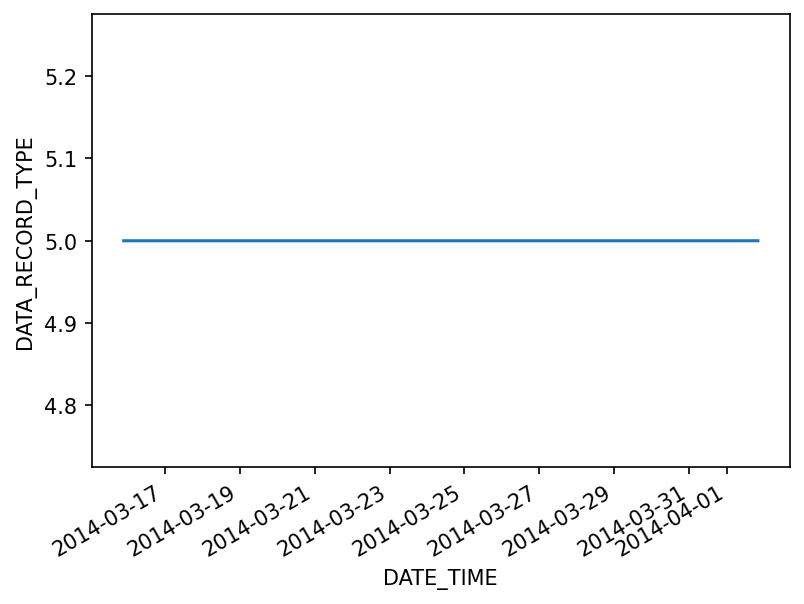

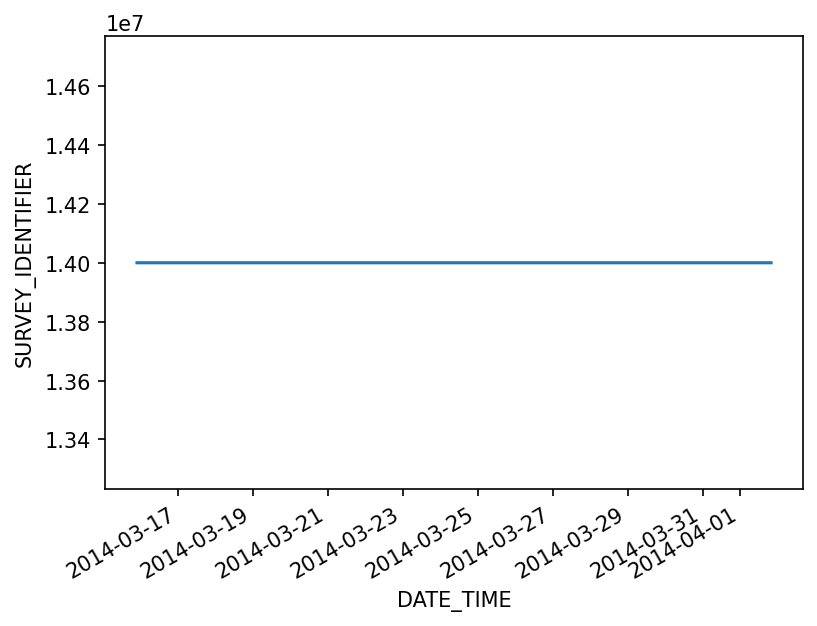

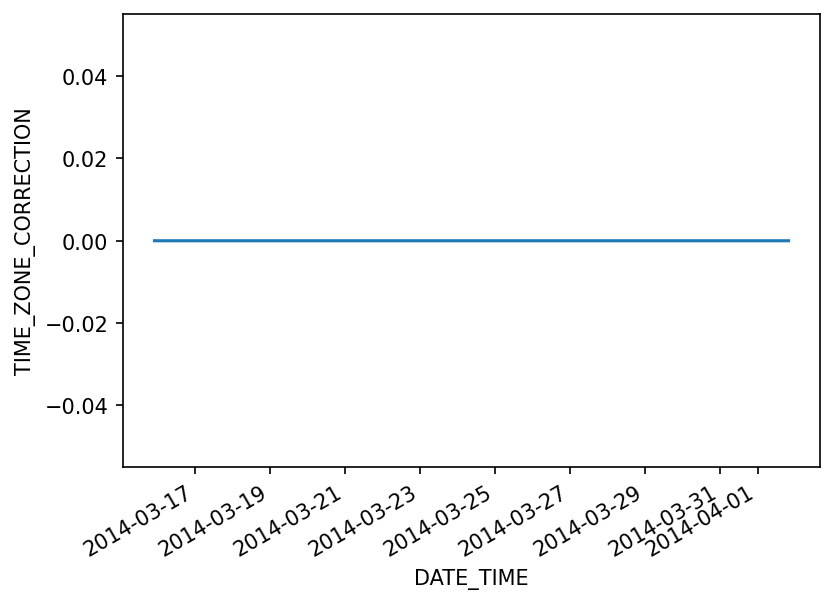

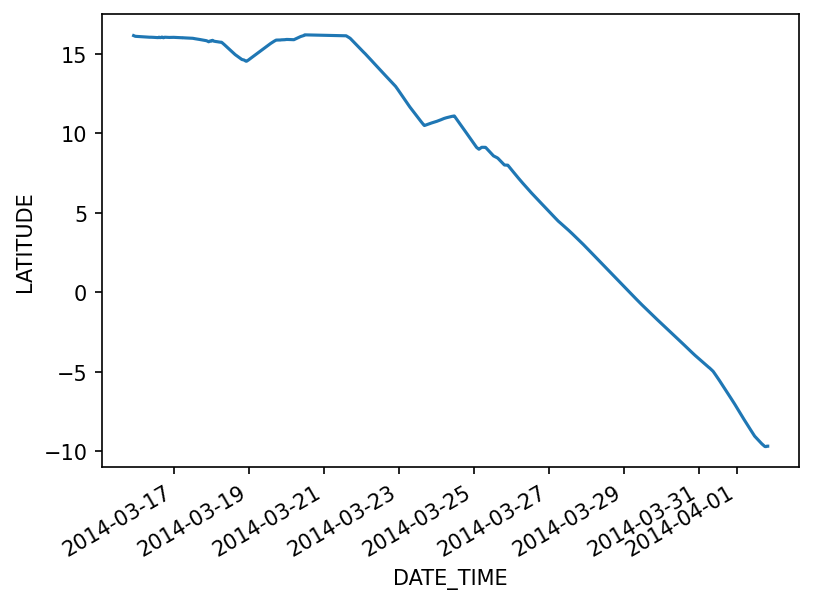

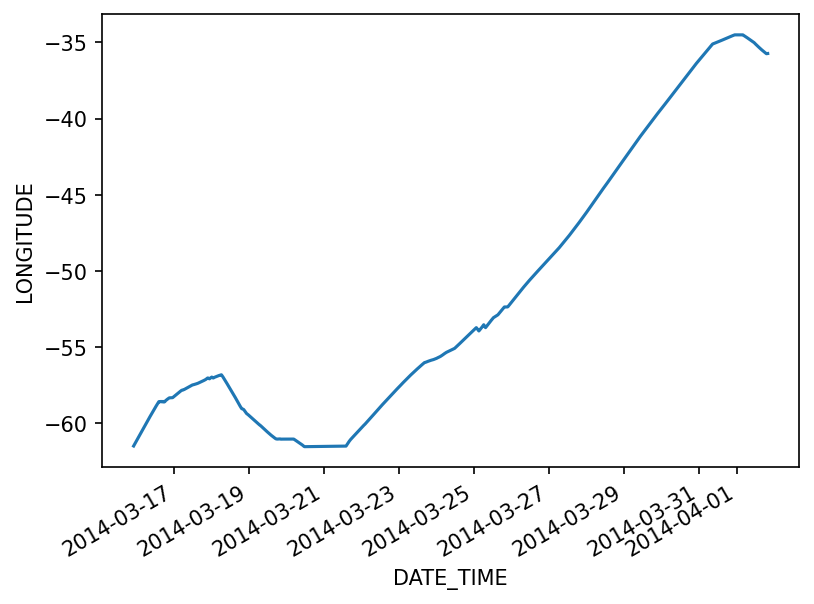

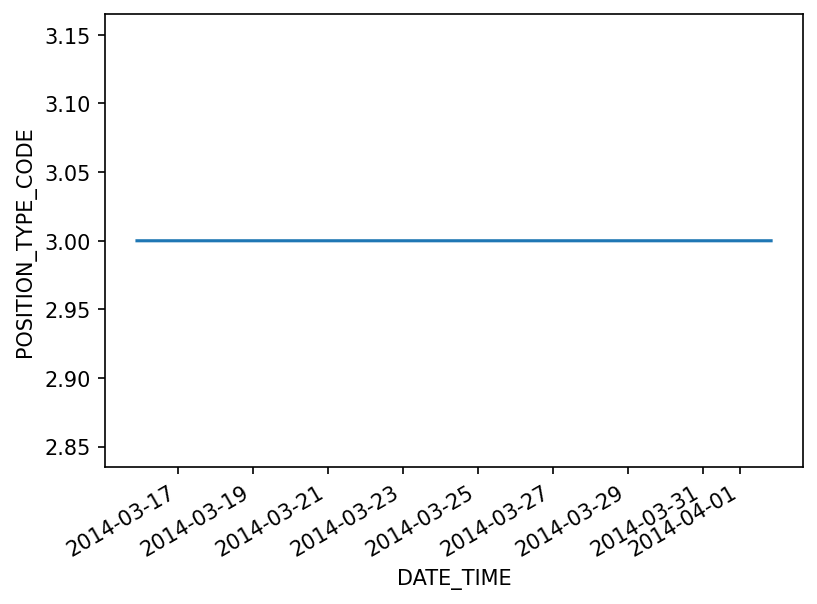

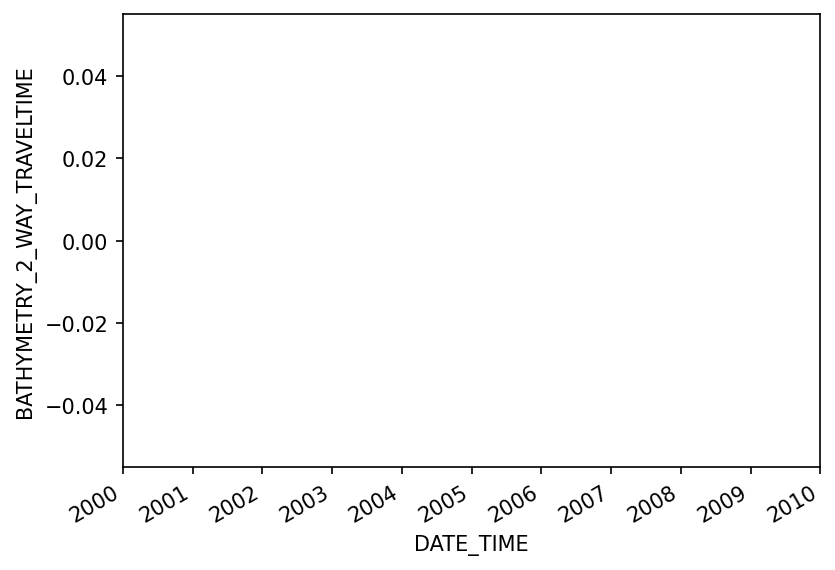

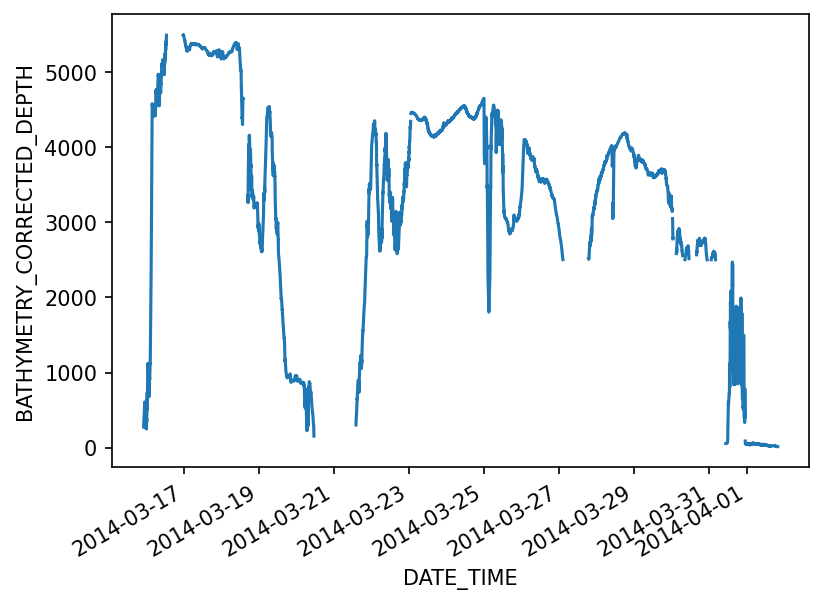

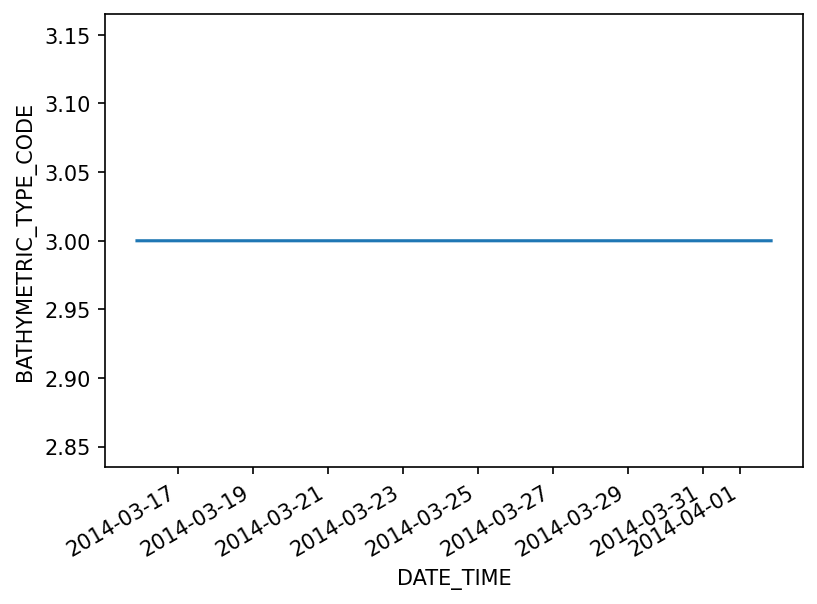

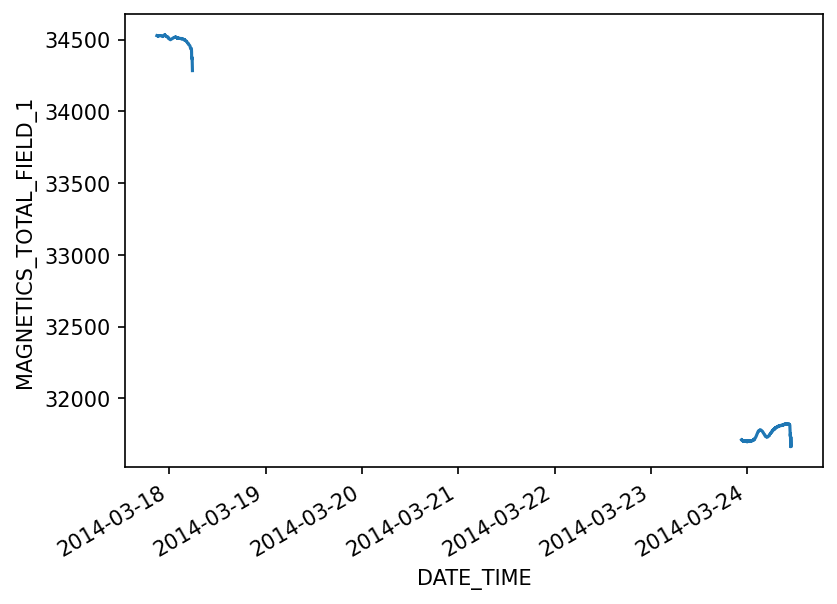

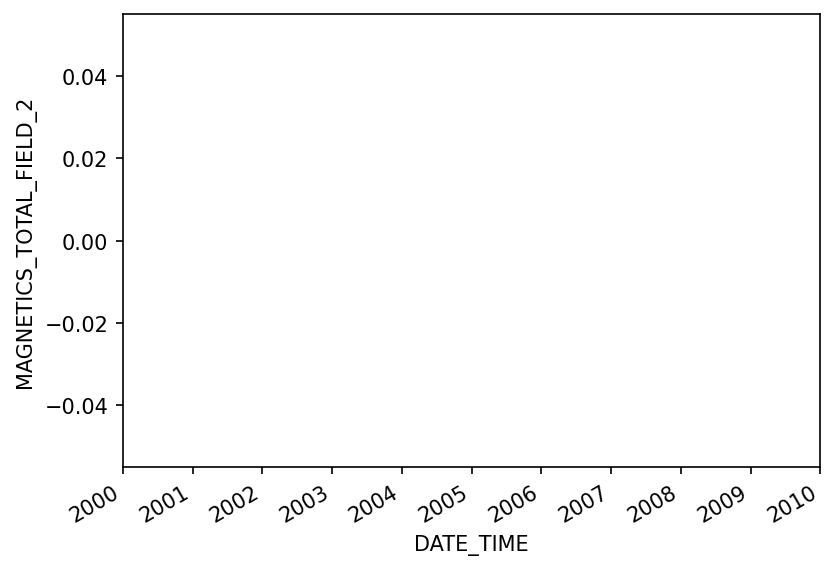

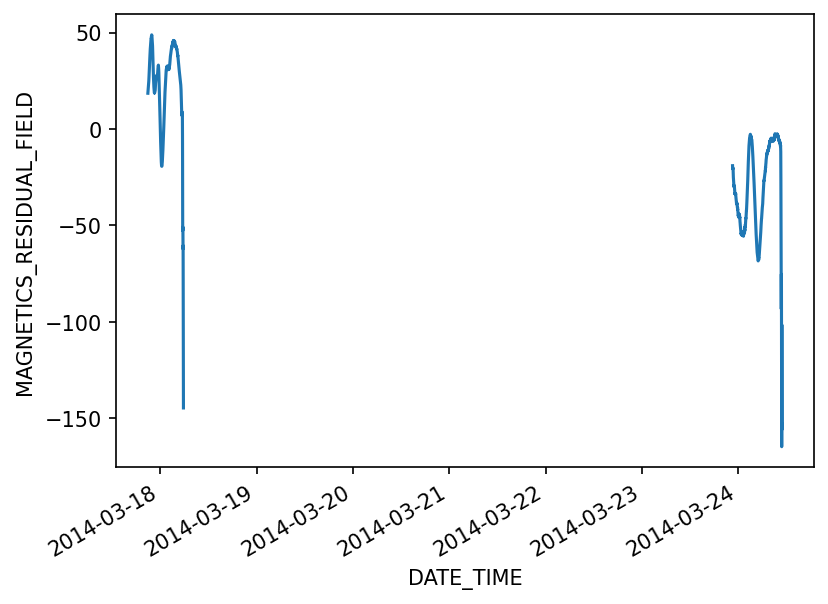

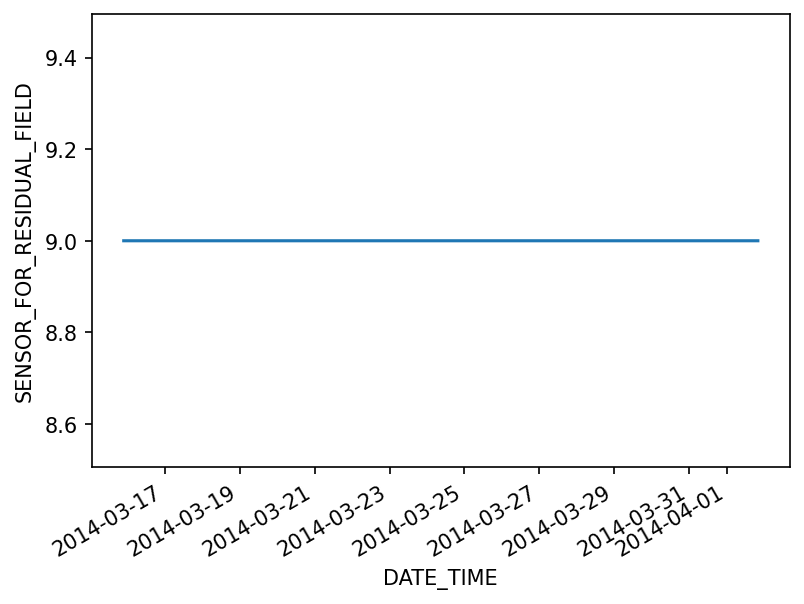

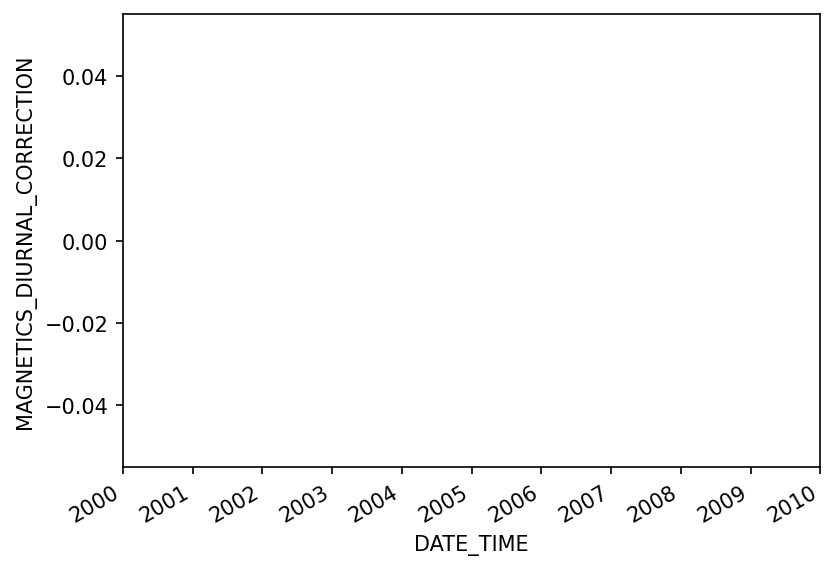

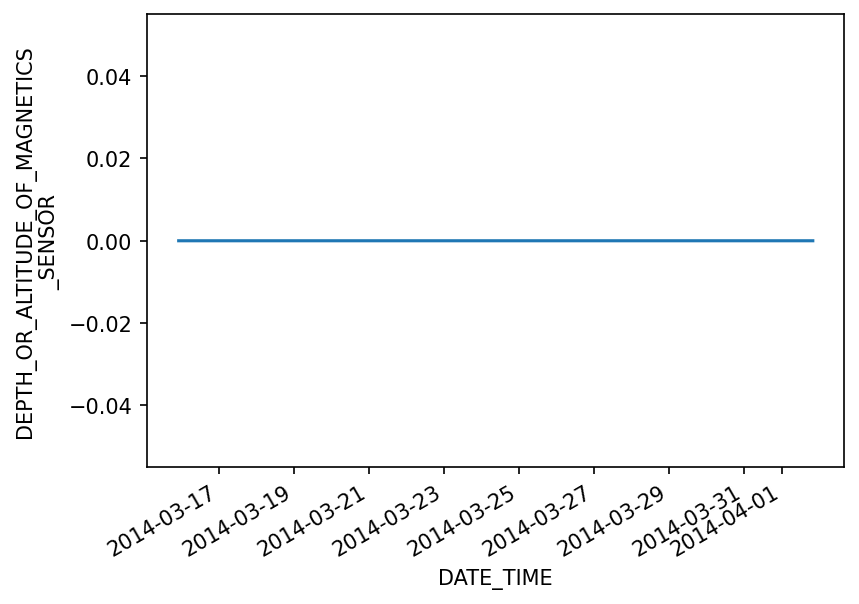

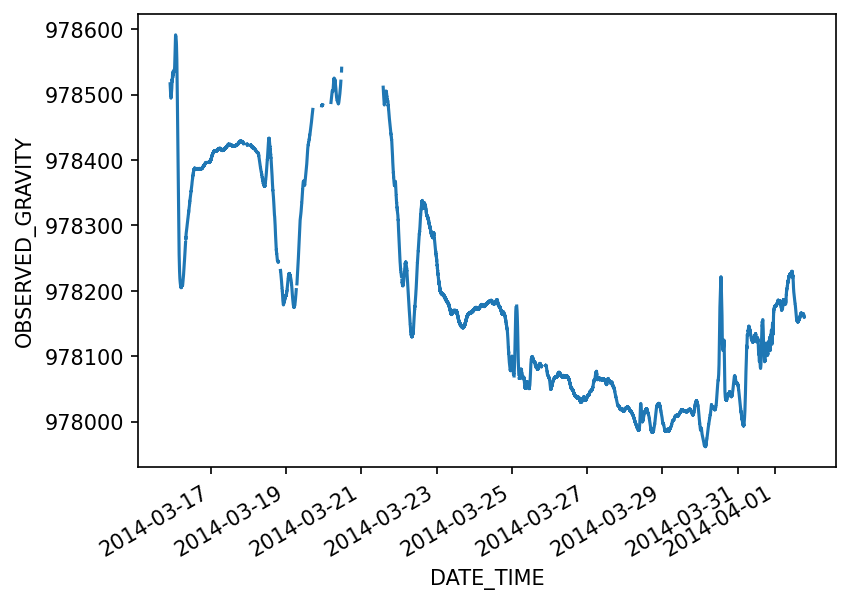

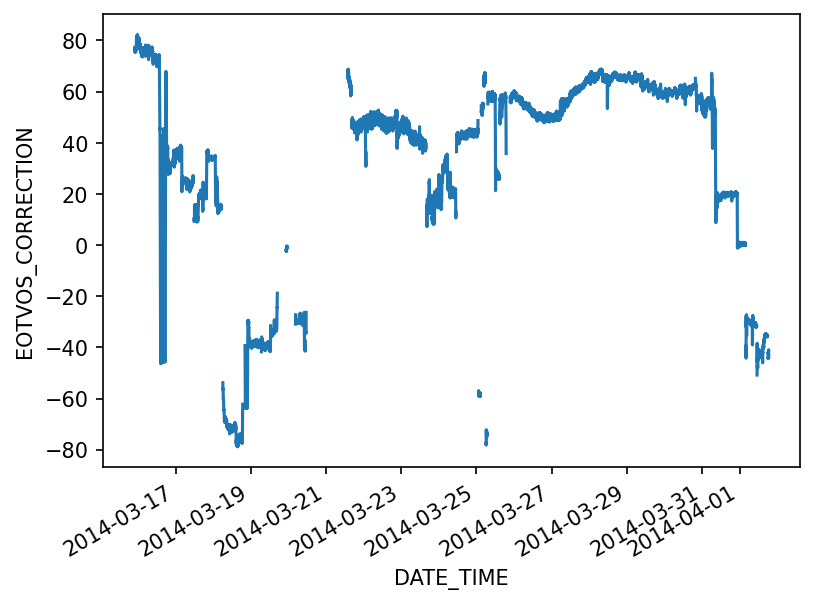

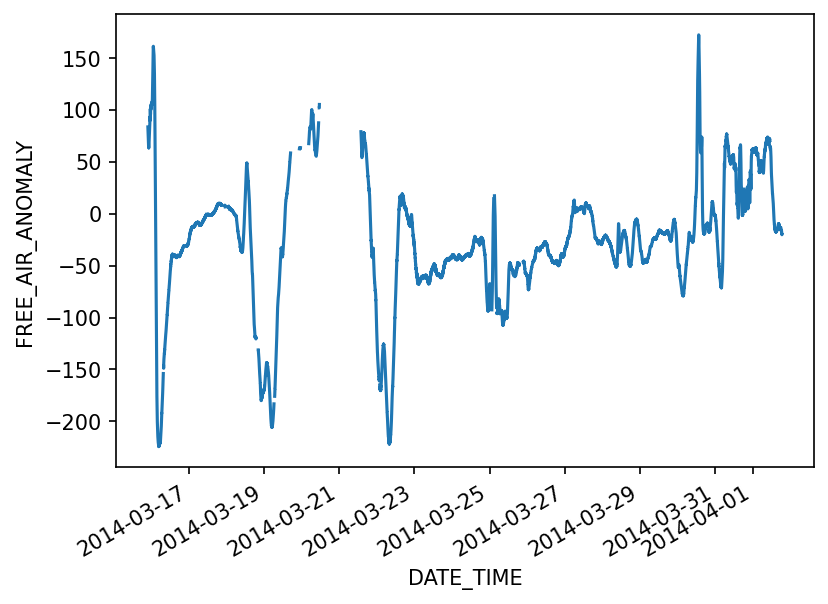

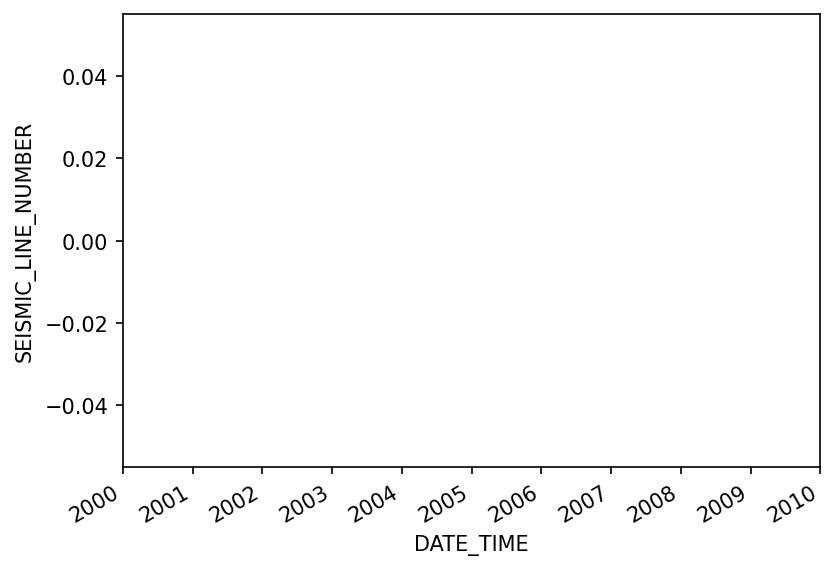

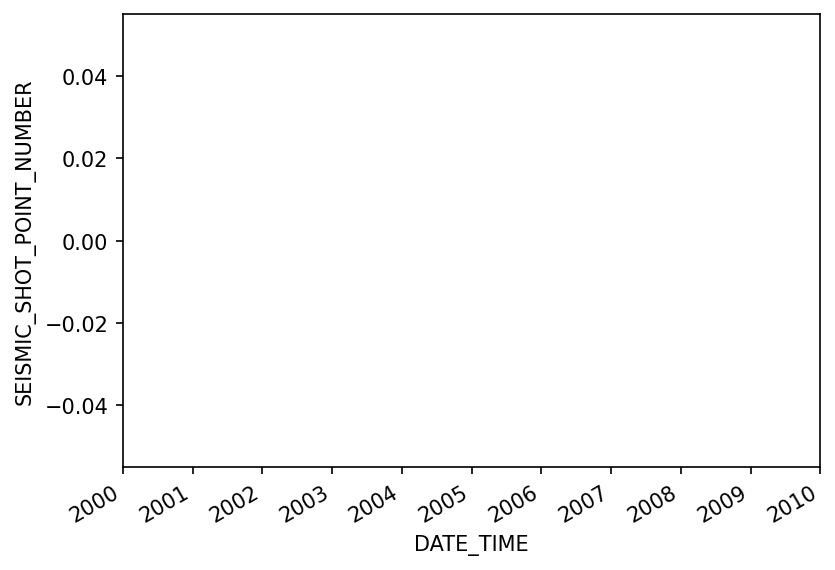

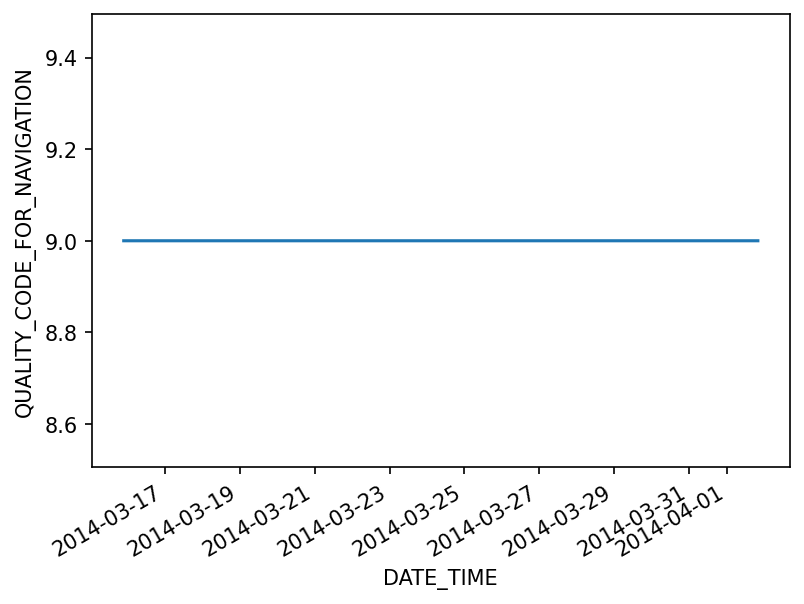

In [11]:
plt.rcParams['figure.dpi'] = 150
for record in Mgd77Data :
    if record != Mgd77Data.DATE_TIME and record != Mgd77Data.BATHYMETRIC_CORRECTION_CODE:
        print(record.name)
        fig, axes = plt.subplots()
        mgd77_ds[record.name].plot()

In [ ]:
techsas_ds = export_to_mgd77(gravi_file, mag_file)
#cut = techsas_ds.sel(DATE_TIME="2014-03-20 08")
#write_mgd77(techsas_ds, base_path + '2014000700_test.mgd77')

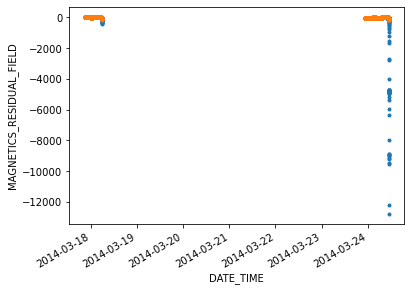

In [16]:
with xr.open_dataset(mag_file) as mag_ds:
    mag_ds['magnetic_anomaly'].plot.line('.')
mgd77_gravity = mgd77_ds[Mgd77Data.MAGNETICS_RESIDUAL_FIELD.name]
mgd77_gravity.plot.line('.')

DATA_RECORD_TYPE
SURVEY_IDENTIFIER
TIME_ZONE_CORRECTION
LATITUDE
LONGITUDE
POSITION_TYPE_CODE
BATHYMETRY_2_WAY_TRAVELTIME
BATHYMETRY_CORRECTED_DEPTH
BATHYMETRIC_TYPE_CODE
MAGNETICS_TOTAL_FIELD_1
MAGNETICS_TOTAL_FIELD_2
MAGNETICS_RESIDUAL_FIELD
SENSOR_FOR_RESIDUAL_FIELD
MAGNETICS_DIURNAL_CORRECTION
DEPTH_OR_ALTITUDE_OF_MAGNETICS_SENSOR
OBSERVED_GRAVITY
EOTVOS_CORRECTION
FREE_AIR_ANOMALY
SEISMIC_LINE_NUMBER
SEISMIC_SHOT_POINT_NUMBER
QUALITY_CODE_FOR_NAVIGATION


C:\dev\miniconda\envs\pyat_dev\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


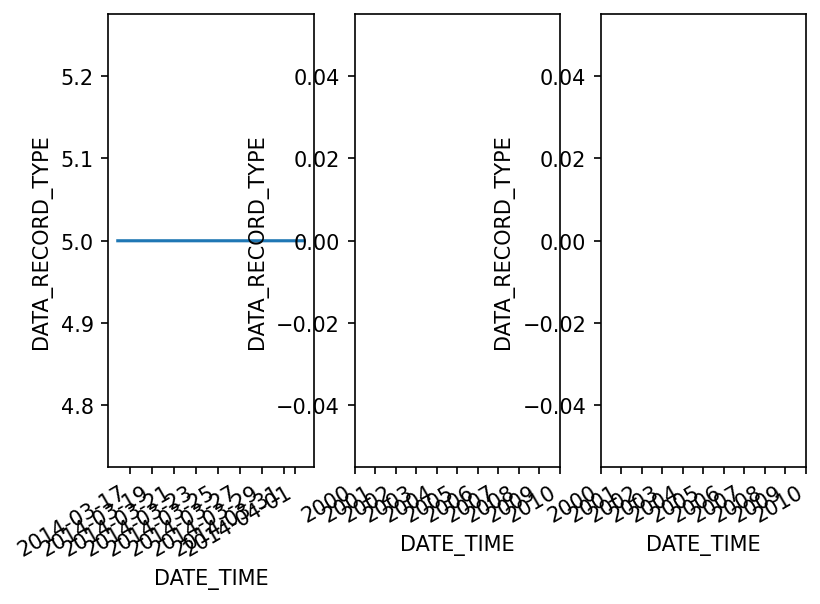

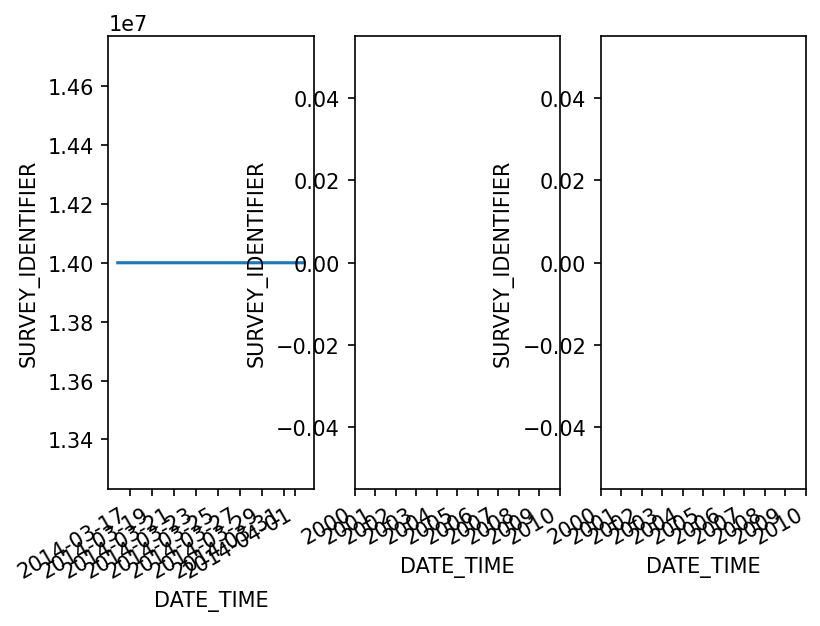

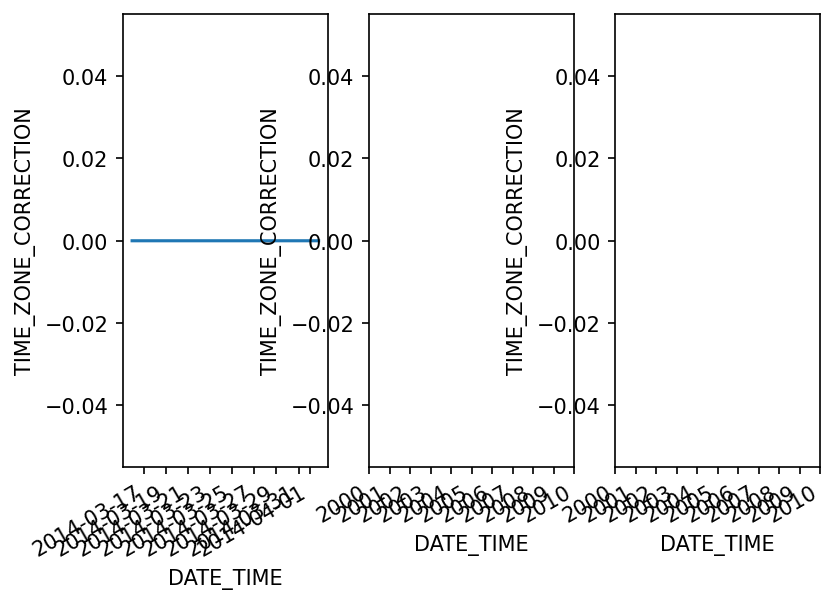

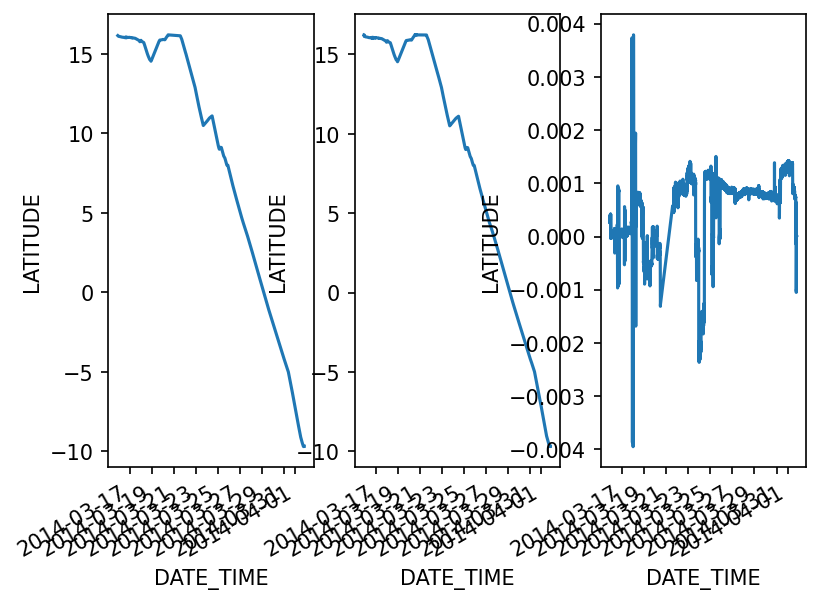

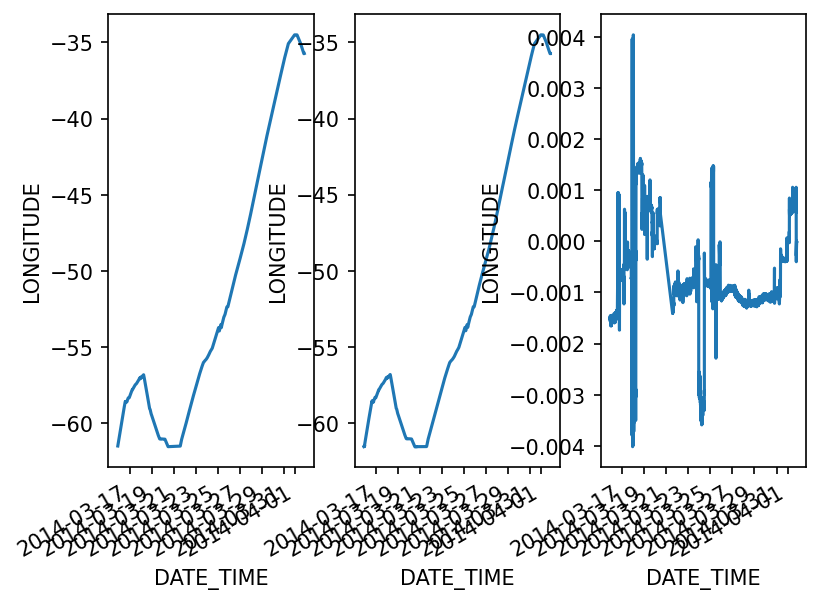

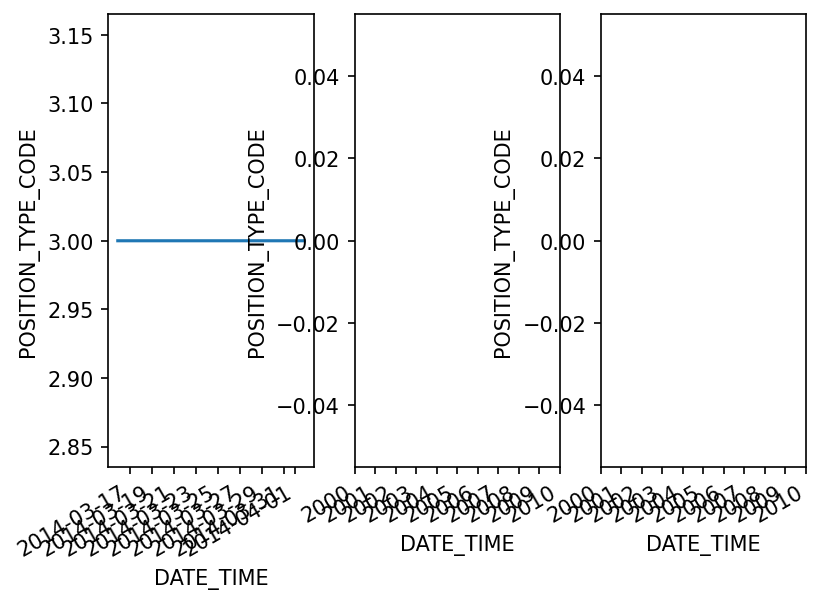

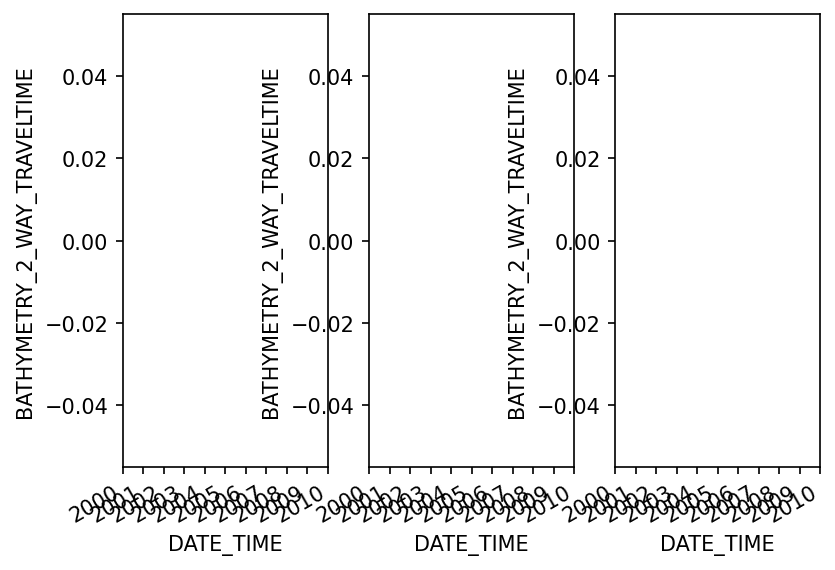

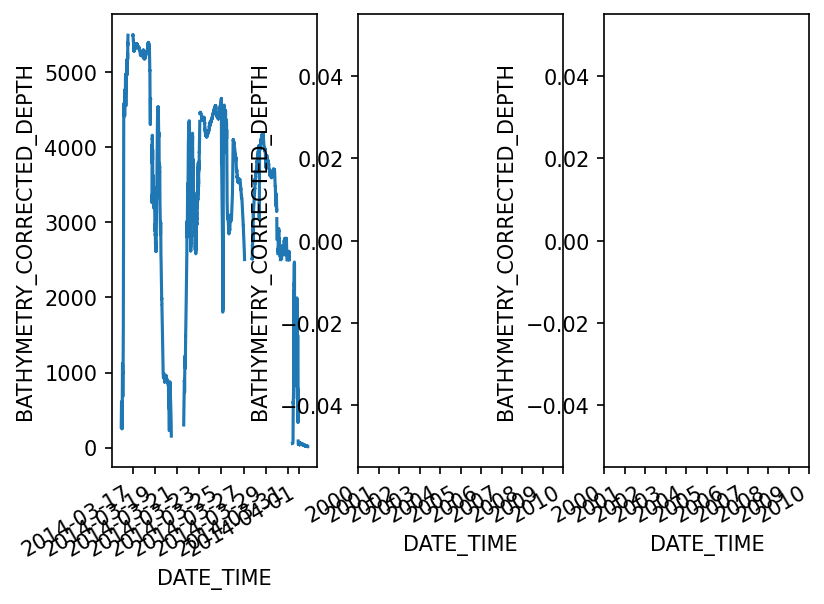

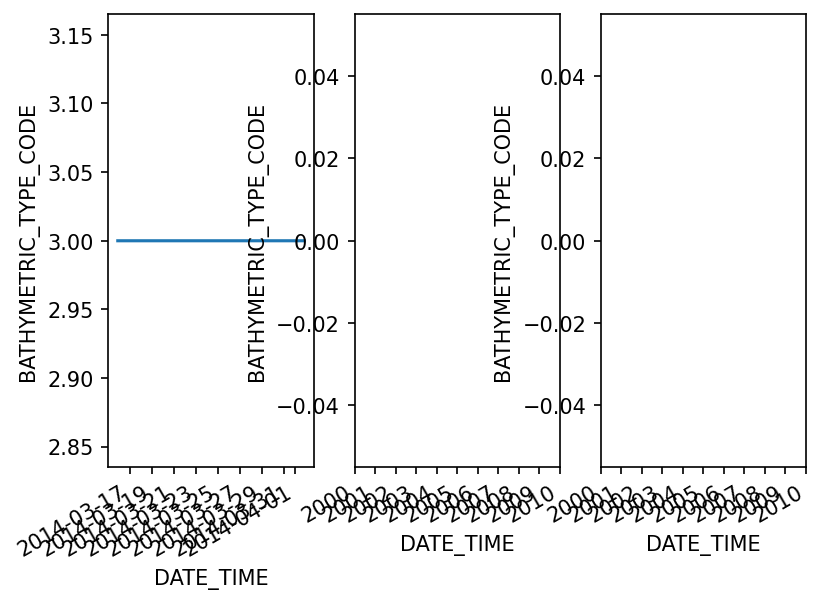

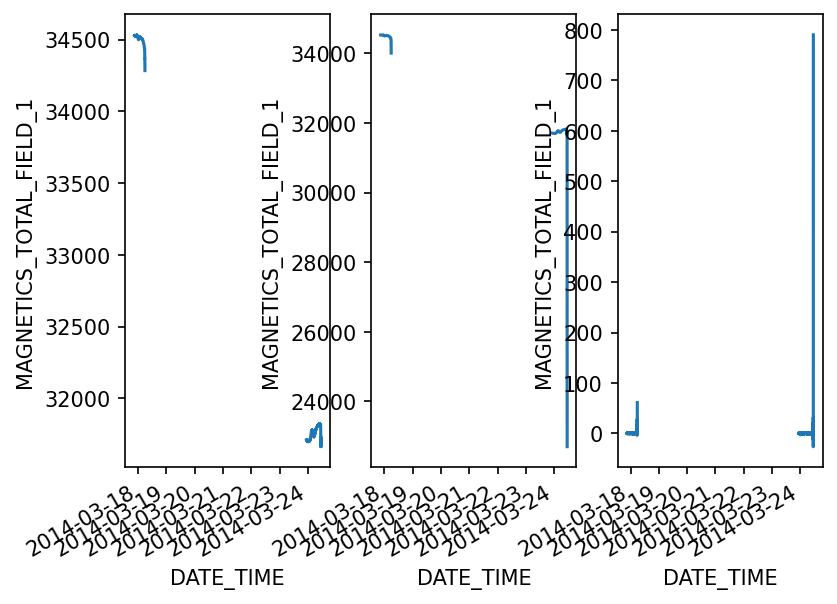

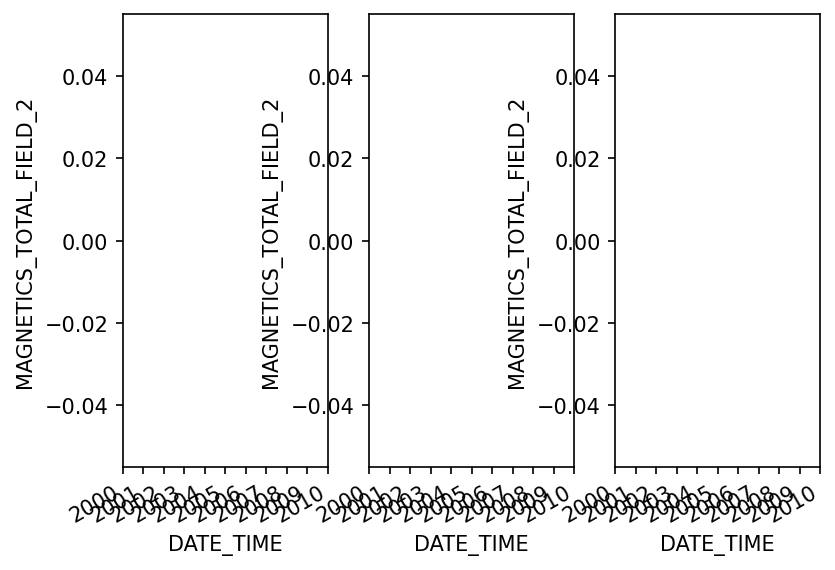

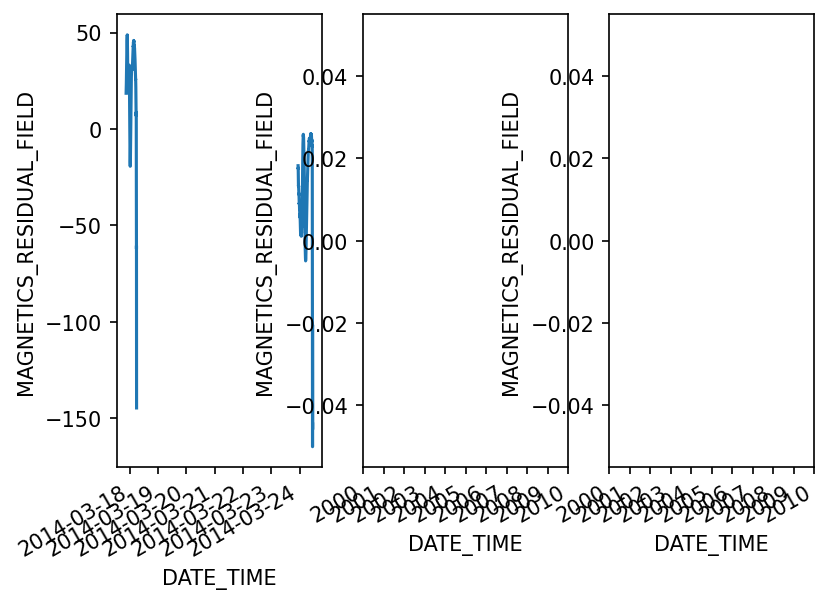

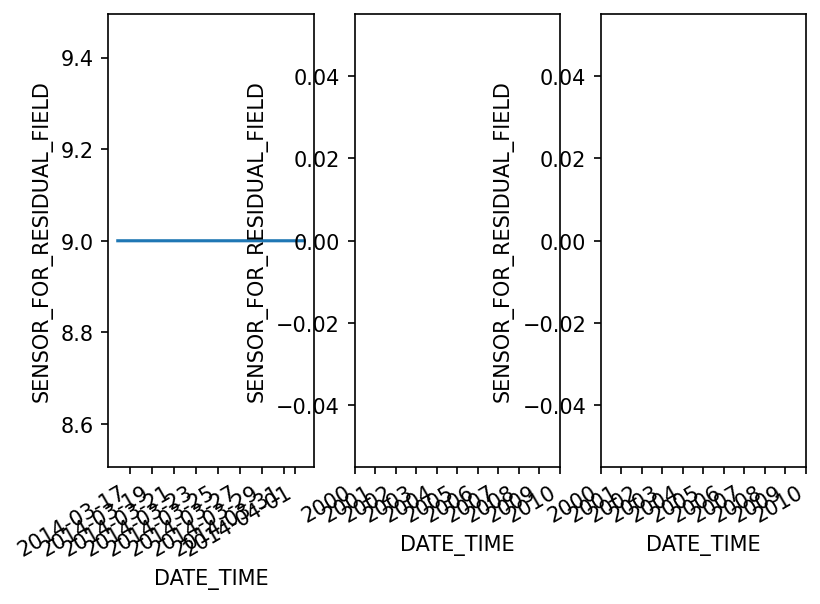

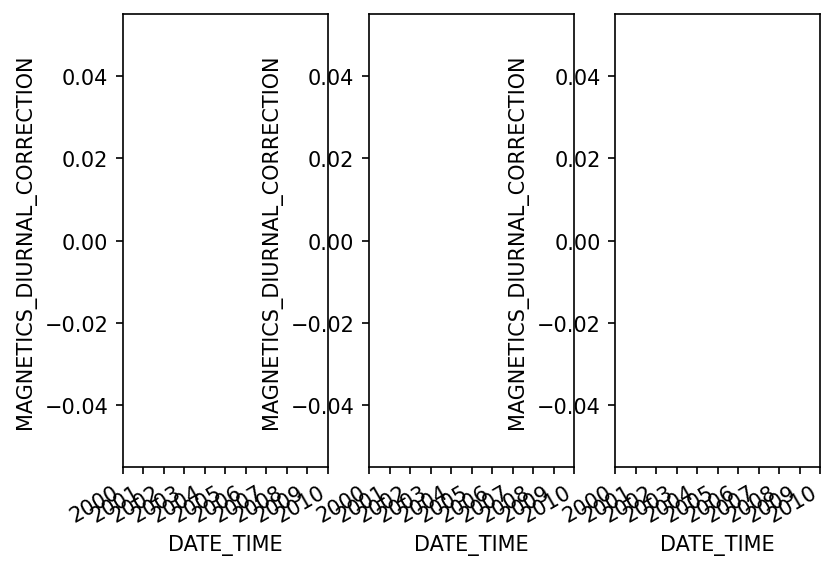

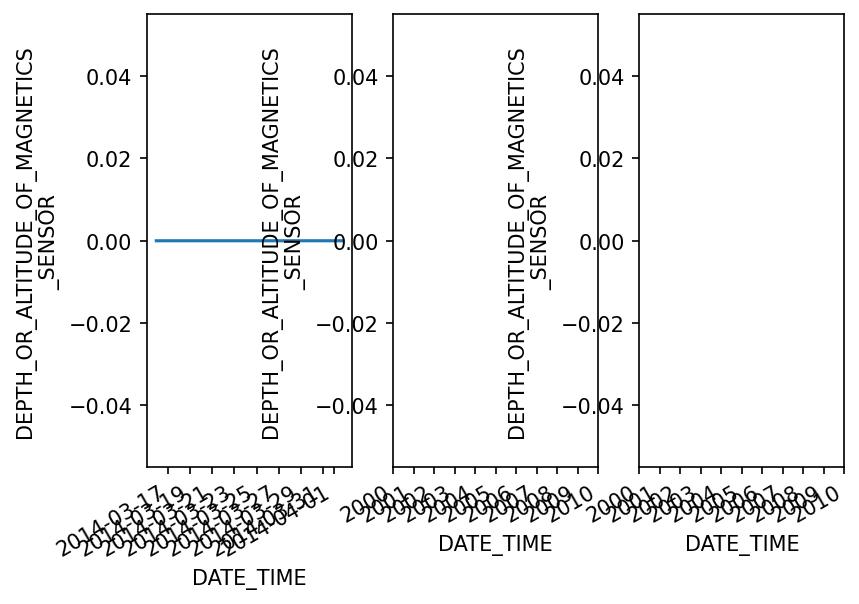

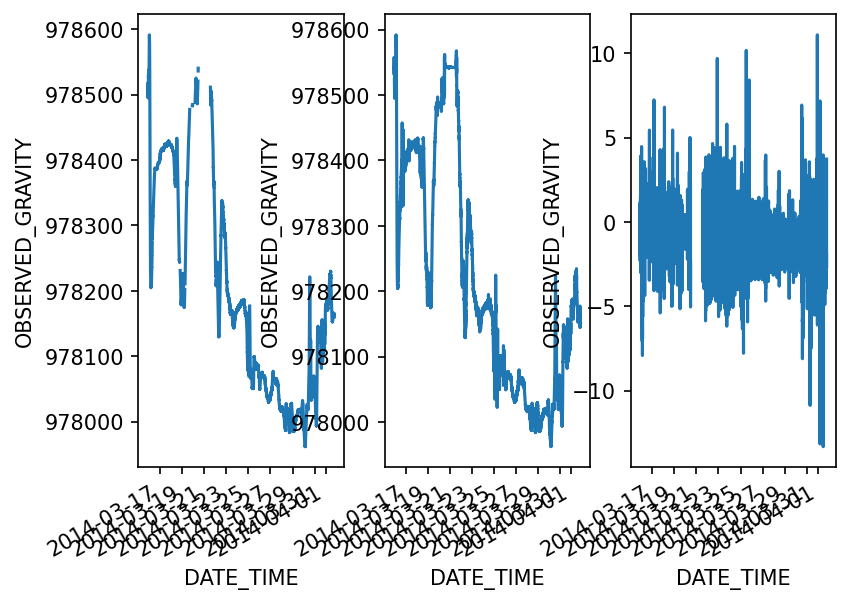

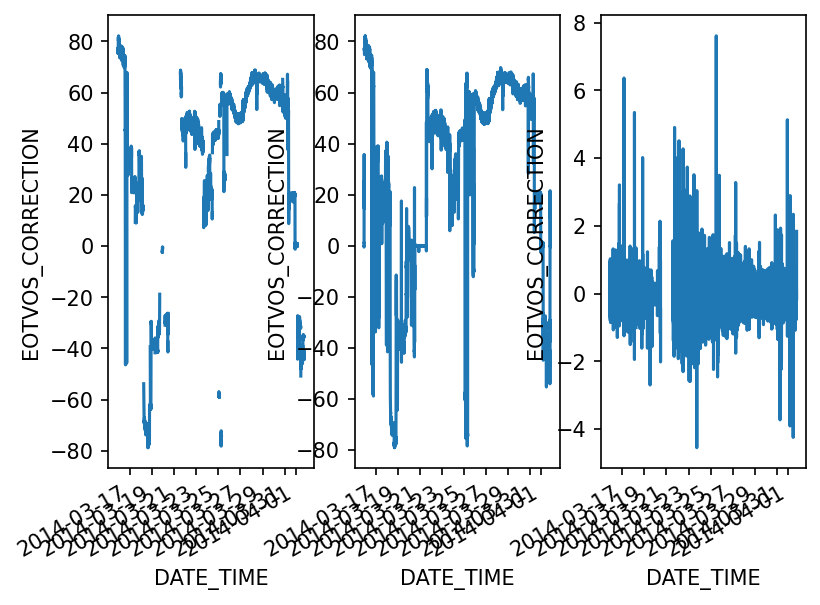

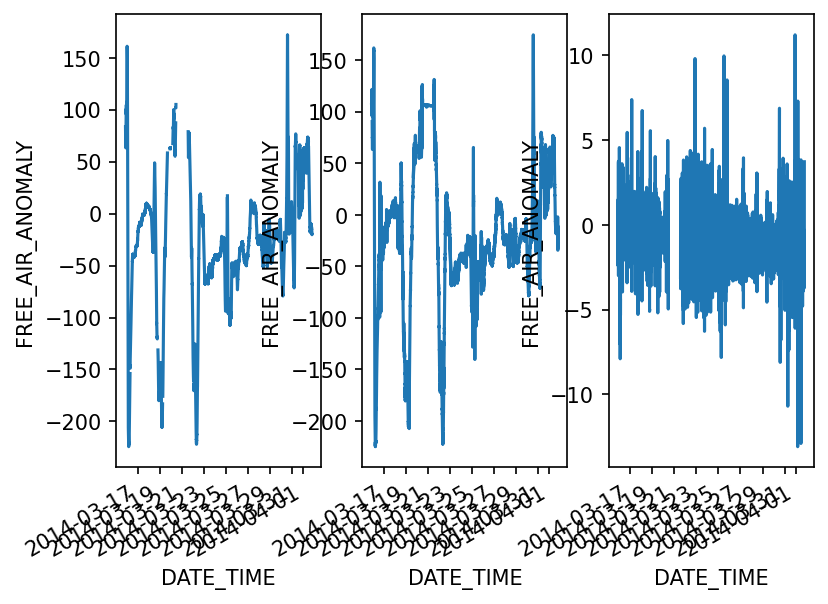

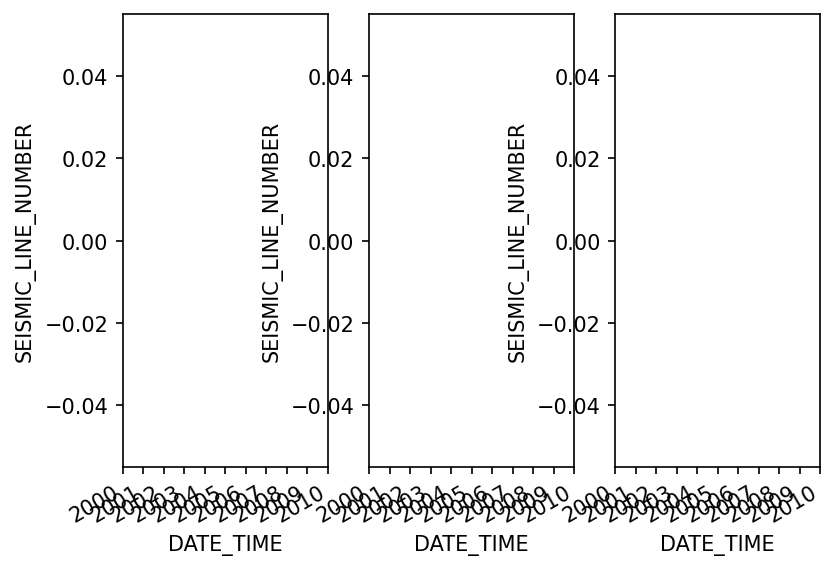

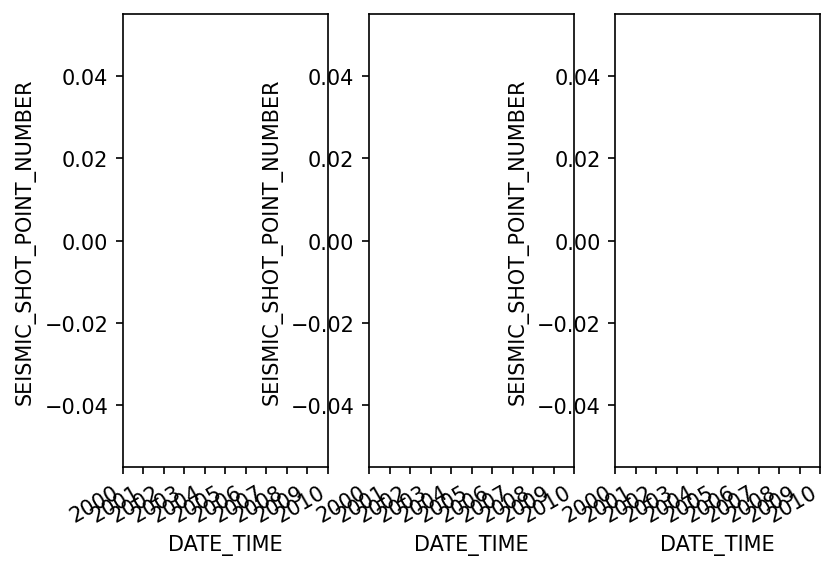

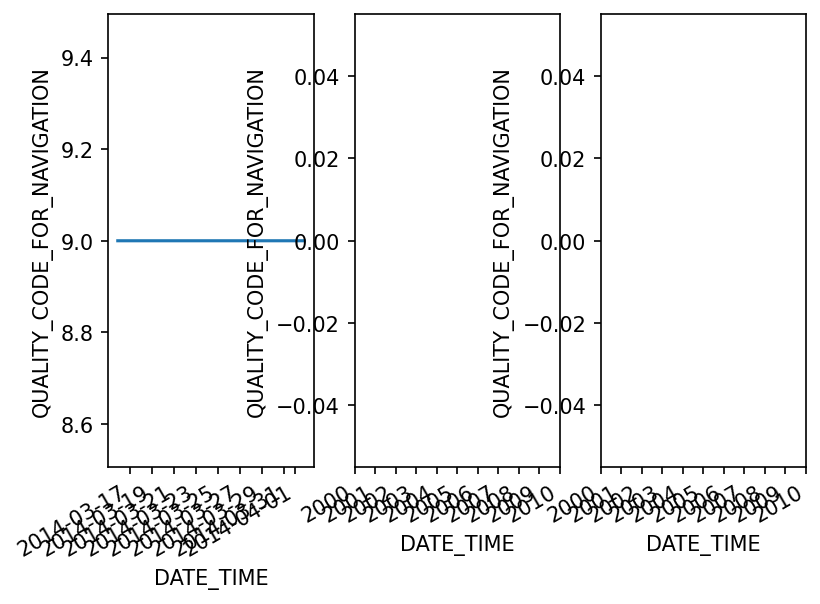

In [50]:
plt.rcParams['figure.dpi'] = 150
for record in Mgd77Data :
    if record != Mgd77Data.DATE_TIME and record != Mgd77Data.BATHYMETRIC_CORRECTION_CODE:
        print(record.name)
        fig, axes = plt.subplots(ncols=3)
        mgd77_ds[record.name].plot(ax=axes[0])
        #techsas_ds[record.name].plot(ax=axes[1])
        (mgd77_ds[record.name] - techsas_ds[record.name]).plot(ax=axes[2])

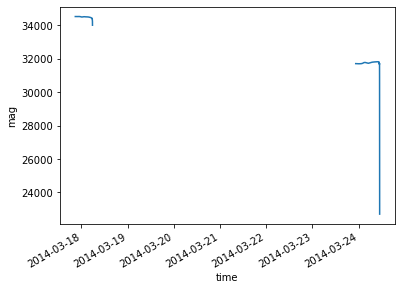

In [121]:
techsas_gravity = techsas_ds['mag']
techsas_gravity.plot()
mgd77_gravity = mgd77_ds[Mgd77Data.MAGNETICS_TOTAL_FIELD_1.name]
#mgd77_gravity.plot()

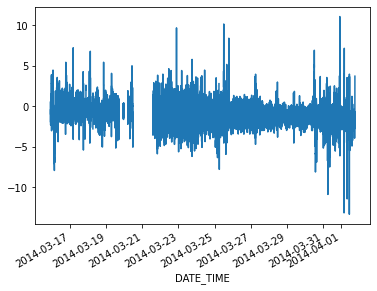

In [111]:
techsas_gravity_2 = techsas_gravity.rename(time=Mgd77Data.DATE_TIME.name)
diff = mgd77_gravity-techsas_gravity_2
diff.plot()

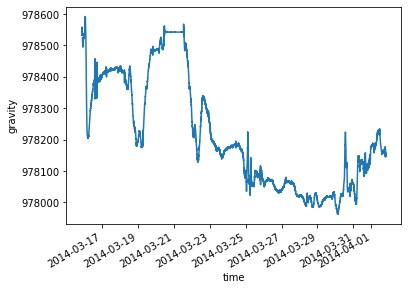

In [105]:
techsas_gravity.interp_like(mgd77_gravity).plot()

In [103]:
mgd77_gravity

<xarray.DataArray 'OBSERVED_GRAVITY' (DATE_TIME: 22316)>
array([978516.6, 978515.6, 978514.7, ...,      nan,      nan,      nan])
Coordinates:
  * DATE_TIME  (DATE_TIME) datetime64[ns] 2014-03-15T21:53:00 ... 2014-04-01T...

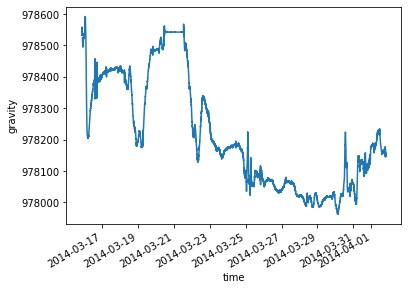

In [94]:
techsas_gravity.interp_like(mgd77_gravity).plot()

In [ ]:
# test simple write with formatters
index = 0
size = 0
with open(base_path + "myfile16h28.txt", "w", encoding="utf-8") as f:
    index = 0
    def print_row(input_data):
        line = ''
        for record in Mgd77Data :
            value =  input_data[record.name].values if record.name in input_data.variables else record.default
            line += '_' + record.write_formatter(value)
        f.write(line + '\n')
        #print(input_data.variables)
        global index 
        index += 1
        if index % 1000 == 0:
            print(f'{index} ...')
        return input_data
    
    #mgd77_ds.sel(datetime="2014-03-20 09").groupby('datetime').map(print_row)
    mgd77_ds.groupby('datetime').map(print_row)
    f.flush()